In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import copy
from tensorflow import keras
from tensorflow.keras import layers, initializers
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import tensorflow_datasets as tfds
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)
assert float(tf.__version__[:3]) >= 2.3

#tfds.list_builders()

In [ ]:
train_data, info = tfds.load("cifar10", split="train[10%:]", with_info = True)
valid_data = tfds.load("cifar10", split="train[:10%]")
test_data = tfds.load("cifar10", split="test")

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.0,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



In [ ]:
def parse_aug_fn(dataset):
    def zoom(x, sh = 299, sw = 299):
        x = tf.image.resize(x, (sh, sw))
        return x
    
    # 影像標準化
    x = tf.cast(dataset['image'], tf.float32) / 255.
    # 影像放大到224*224
    x = zoom(x)
    y = tf.one_hot(dataset['label'], 10)
    y = y
    
    return x, y

In [ ]:
model_dir = '/content/drive/My Drive/Colab Notebooks/cifar10/models'
model = tf.keras.models.load_model(model_dir + "/Best-model-InceptionV3-L2.h5")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 128
train_num = int(info.splits['train'].num_examples / 10) * 9
train_data = train_data.shuffle(train_num)
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
train_data = train_data.batch(batch_size)
  
valid_data = valid_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
valid_data = valid_data.prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.batch(batch_size)
 
test_data = test_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.batch(batch_size)

In [ ]:
#模型儲存目錄
model_dir = '/content/drive/My Drive/Colab Notebooks/cifar10/models'
if os.path.isdir(model_dir):
    print("已存在路徑「{}」".format(model_dir))
else:
    print("已建立路徑「{}」".format(model_dir))
    os.makedirs(model_dir)

已存在路徑「/content/drive/My Drive/Colab Notebooks/cifar10/models」


In [ ]:
#回調函數
log_dir = os.path.join('content','drive','My Drive','Colab Notebooks','cifar10','InceptionV3-L2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + "/Best-model-InceptionV3-L2.h5", monitor='val_categorical_accuracy', mode='max')
# model_esp = keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=300, mode='max')

In [ ]:
# input_shape = (299, 299)
# base_model = tf.keras.applications.InceptionV3(include_top = False,
#                                               weights="imagenet",
#                                               pooling='avg',
#                                               input_shape=input_shape+(3,))
# model=tf.keras.Sequential([
#     base_model,
#     layers.Dense(1024,activation='relu', kernel_regularizer = 'l2'),
#     layers.Dense(10,activation='softmax')
# ])
 
# for layer in model.layers:
#     layer.trainable = False
# # 或者使用如下方法凍結所有層
# # model.trainable = False 
# model.layers[-1].trainable = True
# model.layers[-2].trainable = True

###顯示可以訓練的所有層
# for x in model.trainable_weights:
#     print(x.name)

###顯示不可訓練的所有層
# for x in model.non_trainable_weights:
#     print(x.name)
 


In [ ]:
#優化器、損失函數，指標函數
model.compile(keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total params: 23,911,210
Trainable params: 2,108,426
Non-trainable params: 21,802,784
_________________________________________________________________


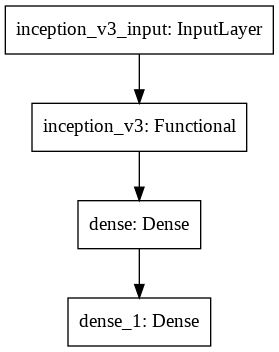

In [ ]:
plot_model(model)

In [ ]:
##因為已訓練，故不再訓練

# 有EarlyStopping
# history = model.fit(train_data, epochs=1000, validation_data = valid_data, callbacks=[model_cbk, model_mckp, model_esp])
# history = model.fit(train_data, epochs=1000, validation_data = valid_data, callbacks=[model_cbk, model_mckp])

In [ ]:
model.evaluate(train_data)

352/352 [==============================] - 207s 589ms/step - loss: 0.4403 - categorical_accuracy: 0.8744


[0.44029539823532104, 0.8744444251060486]

In [ ]:
model.evaluate(valid_data)

40/40 [==============================] - 24s 594ms/step - loss: 0.5309 - categorical_accuracy: 0.8484


[0.5308846831321716, 0.8483999967575073]

In [ ]:
model.evaluate(test_data)

79/79 [==============================] - 29s 367ms/step - loss: 0.5511 - categorical_accuracy: 0.8439


[0.5510786175727844, 0.8439000248908997]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/tmphwcbdi62/assets


INFO:tensorflow:Assets written to: /tmp/tmphwcbdi62/assets


In [ ]:
# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

Float model size = 93327KBs.


In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpcm2i22wj/assets


INFO:tensorflow:Assets written to: /tmp/tmpcm2i22wj/assets


In [ ]:
# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

Quantized model size = 23437KBs,
which is about 25% of the float model size.


In [ ]:
train_data, info = tfds.load("cifar10", split="train[10%:]", with_info = True)
valid_data = tfds.load("cifar10", split="train[:10%]")
test_data = tfds.load("cifar10", split="test")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
test_num = int(info.splits['test'].num_examples / 10) * 9
test_data = test_data.shuffle(test_num)
test_data = test_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# 設定測試資料量
n = int(input("請輸入test數量\n"))
test_data_np = list(tfds.as_numpy(test_data.take(n)))

## 會使用list是因為tfds.as_numpy產生出了的是generator
## 在下面evaluate_tflite_model的function中，
## 如果要重複呼叫函數數次，轉成list才不會error，
## 因為generator執行過後的值會不見(節省記憶體)。

請輸入test數量
50


In [ ]:
def evaluate_tflite_model(tflite_model):
  print("共有%d張測試資料。"%n)
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])
 
  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  i = 0
  accurate_count = 0
  test_labels = []
  for data in test_data_np:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    # test_image = np.expand_dims(np.array(data[0]), axis=0).astype(np.float32)
    test_image = np.expand_dims(data[0], axis=0).astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_image)
 
    # Run inference.
    interpreter.invoke()
 
    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)
    
    test_labels.append(np.argmax(data[1]))
    # print("digit:",prediction_digits[i],"labels:",labels[i])
 
    
    i+=1
    if i%100 == 0:
      print('已讀取{}張圖片。'.format(i))
      # for index in range(len(prediction_digits)):
      #   if prediction_digits[index] == test_labels[index]:
      #     accurate_count += 1
      # accuracy = accurate_count * 1.0 / len(prediction_digits)
      # print(accuracy)
    
    
 
  # Compare prediction results with ground truth labels to calculate accuracy.
  
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)
 
  return accuracy

In [ ]:
float_accuracy = evaluate_tflite_model(tflite_float_model)
print('Float model accuracy = %.4f' % float_accuracy)

共有50張測試資料。
Float model accuracy = 0.8400


In [ ]:
quantized_accuracy = evaluate_tflite_model(tflite_quantized_model)
print('Quantized model accuracy = %.4f' % quantized_accuracy)

共有50張測試資料。
Quantized model accuracy = 0.8000
